# めちゃめちゃ参考文献

https://www.youtube.com/@user-ej3zj6kv9z

そーすこーどとかほぼパクリなので, 使用の際は気を付けて

# import

In [31]:

import pandas as pd
from tqdm.notebook import tqdm as tqdm
from graphviz import *
import lightgbm as lgb
from hyperopt import hp, tpe, Trials, fmin,STATUS_OK
import pickle
from my_modules.constants import LocalPaths,UrlPaths
from my_modules import prepare,funcs,preprocess,simulator
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#  データロード ※更新2023/02/02

In [2]:
race_results = pd.read_csv(LocalPaths.RESULTS_PATH,index_col=0)
horse_results = pd.read_csv(LocalPaths.HORSE_RESULTS_PATH,index_col=0)
peds = pd.read_csv(LocalPaths.PEDS_PATH,index_col=0)
peds.fillna('nan',inplace=True) # 何回やってもロードすると, nanが出る
return_tables = pd.read_csv(LocalPaths.RETURN_PATH,index_col=0)
return_tables.rename(columns={'0':0,'1':1,'2':2,'3':3},inplace=True)# 毎回読み込むごとに, strに変換されてしまう

# データ収集

In [7]:
# toの月は含まないので注意
kaisai_date_list = prepare.scrape_kaisai_date(from_="2023-01-01",to_='2023-02-01')

getting race date from 2023-01-01 to 2023-02-01


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


In [ ]:
race_id_list = prepare.scrape_race_id_list(kaisai_date_list)

In [21]:
# データ収集
new_return_tables = prepare.scrape_return_tables(race_id_list)
# データ更新
return_tables = pd.read_csv(LocalPaths.RETURN_PATH,index_col=0)
return_tables.rename(columns={'0':0,'1':1,'2':2,'3':3},inplace=True)
new_return_tables.rename(columns={'0':0,'1':1,'2':2,'3':3},inplace=True)
update_return_tables = funcs.update_data(return_tables,new_return_tables)
update_return_tables.to_csv(LocalPaths.RETURN_PATH)


In [9]:
# データ収集
new_race_results = prepare.scrape_race_results(race_id_list)
# データ更新
race__results = pd.read_csv(LocalPaths.RESULTS_PATH,index_col=0)
update_race_results = funcs.update_data(race_results,new_race_results)
update_race_results.to_csv(LocalPaths.RESULTS_PATH)

  0%|          | 0/312 [00:00<?, ?it/s]

In [10]:
# データ収集
horse_id_list = new_race_results['horse_id'].unique()
new_horse_results = prepare.scrape_horse_results(horse_id_list)
# データ更新
horse_results = pd.read_csv(LocalPaths.HORSE_RESULTS_PATH,index_col=0)
update_horse_results = funcs.update_data(horse_results,new_horse_results)
update_horse_results.to_csv(LocalPaths.HORSE_RESULTS_PATH)

  0%|          | 0/3662 [00:00<?, ?it/s]

In [ ]:
# データ収集
new_peds = prepare.scrape_peds(horse_id_list)
# データ更新
peds = pd.read_csv(LocalPaths.PEDS_PATH,index_col=0)
update_peds = funcs.update_data(peds,new_peds)
update_peds.to_csv(LocalPaths.PEDS_PATH)

# データ形式

### データ　見た目こんな感じ

## race_results ※更新
trainer_id, owner_id を追加
過去のcsvファイルと異なるので, 注意

In [4]:
"""
    レース結果を記録したテーブル
    results.index : Int64Index, index は race_id
    index だけでは一意にレコードが求まらないので, 注意
"""
race_results.head() # index : race_id

,着順,枠番,馬番,馬名,性齢,斤量,騎手,タイム,着差,単勝,...,調教師,course_len,weather,race_type,ground_state,date,horse_id,jockey_id,trainer_id,owner_id
202306010101,1,7,14,シュバルツガイスト,牡3,56,武豊,1:12.6,NaN,1.8,...,[東] 国枝栄,1200,晴,ダート,良,2023年1月5日,2020103575,666,399,356803
202306010101,2,3,5,ジェイケイファイン,牡3,56,内田博幸,1:12.9,1.3/4,7.4,...,[東] 奥平雅士,1200,晴,ダート,良,2023年1月5日,2020107073,422,1074,702009
202306010101,3,1,1,レディアス,牝3,54,津村明秀,1:12.9,クビ,36.1,...,[東] 鈴木慎太,1200,晴,ダート,良,2023年1月5日,2020102562,1092,1179,763033
202306010101,4,8,15,ハローマイラブリー,牝3,54,三浦皇成,1:13.4,3,4.2,...,[東] 伊坂重信,1200,晴,ダート,良,2023年1月5日,2020106345,1122,1177,729005
202306010101,5,5,9,ベアカワイコチャン,牝3,54,松岡正海,1:13.9,3,7.9,...,[東] 杉浦宏昭,1200,晴,ダート,良,2023年1月5日,2020100039,1085,1008,372033


In [7]:
""" 
    馬の過去の全戦績を記したテーブル
    horse_results.index : Int64Index, index は horse_id
    indexはhorse_id
    こちらも, index だけでは一意にレコードが定まらないので注意
"""
horse_results.head()

,日付,開催,天気,R,レース名,映像,頭数,枠番,馬番,オッズ,...,着差,ﾀｲﾑ指数,通過,ペース,上り,馬体重,厩舎ｺﾒﾝﾄ,備考,勝ち馬(2着馬),賞金
2017105800,2021/07/08,名古屋,曇,7.0,C12組,NaN,10.0,4.0,4.0,6.6,...,NaN,**,4-3,0.0-39.5,NaN,479(-1),NaN,NaN,ナツミフルーリー,NaN
2017105800,2021/06/30,名古屋,曇,5.0,C14組,NaN,10.0,3.0,3.0,12.2,...,0.7,**,5-6-5,0.0-40.3,39.4,480(-4),NaN,NaN,マルカブレーブ,10.2
2017105800,2021/06/16,名古屋,雨,5.0,美穂ちゃんバースデイ,NaN,11.0,2.0,2.0,13.5,...,2.7,**,10-10-8,0.0-38.2,38.4,484(+3),NaN,NaN,タイキスピネル,2.6
2017105800,2021/06/03,名古屋,晴,6.0,C14組,NaN,10.0,8.0,9.0,3.8,...,1.0,**,3-4-4,0.0-39.6,40.1,481(-6),NaN,NaN,トーホウボッカ,NaN
2017105800,2021/05/19,名古屋,雨,5.0,C15組,NaN,11.0,8.0,11.0,29.8,...,0.5,**,3-3-3,0.0-38.4,38.6,487(0),NaN,NaN,キングリアリティー,10.2


In [8]:
""" 
    馬の血統データ
    peds.index : Int64Index, index は horse_id
    カタカナ, 英字が混じっているので, 注意
"""
peds.head() # 5世代分の血統データ

,peds_0,peds_1,peds_2,peds_3,peds_4,peds_5,peds_6,peds_7,peds_8,peds_9,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
2017100590,クロフネ,ハッピーティア,フレンチデピュティ,ブルーアヴェニュー,ホワイトマズル,ハッピーチケット,DeputyMinister,Mitterand,ClassicGoGo,ElizaBlue,...,Tyrant,FlightTable,Halo,WishingWell,Lyphard,Prodice,Herbager,SilverCoin,チャイナロック,ソシアルバターフライ
2017106441,スピルバーグ,ミュージー,ディープインパクト,プリンセスオリビア,ElPrado,Foible,サンデーサイレンス,ウインドインハーヘア,Lycius,DanceImage,...,TomFool,Ghazni,Nasrullah,Lalun,PrinceJohn,NileLily,Turnto,YourGame,RestlessNative,EnchantedEve
2017106225,ケープブランコ,ヒラボクキャロル,Galileo,LaurelDelight,ダンスインザダーク,チョウカイキャロル,SadlersWells,アーバンシー,Presidium,Foudroyer,...,KeytotheMint,NativePartner,HailtoReason,Bramalea,Graustark,GoldenTrail,RaiseaNative,GoldDigger,VaguelyNoble,SleekDancer
2014105693,キンシャサノキセキ,マイワイルドローズ,フジキセキ,ケルトシャーン,WildAgain,RoseofMull,サンデーサイレンス,ミルレーサー,PleasantColony,Featherhill,...,Dante,Clovelly,SwordDancer,Kerala,Buckpasser,Intriguing,Ribot,Pocahontas,DarkStar,Vulcania
2013101632,メイショウサムソン,シルクヴァルキリー,オペラハウス,マイヴィヴィアン,マーベラスサンデー,シルクフレアー,SadlersWells,Colorspin,ダンシングブレーヴ,ウイルプリンセス,...,LaughAloud,HoldMeClose,Nearctic,Natalma,AdmiralsVoyage,Petitioner,RaiseaNative,SweetTooth,ノノアルコ,Mortefontaine


In [12]:
""" 
    return_tables レースの払い戻し金額が記されたテーブル
    return_tables.index : Int64Index, index は race_id
    こちらも, index では一意にレコードが定まらない
    カラムの
        0 : 払い戻し種別
        1 : 馬番, 
            ex) 6 なら 馬番6が払い戻し対象
        2 : 払い戻し金額 (単位 : 円, 100円賭けた時の払い戻し金額), 
            ex) 複勝で カラム(2) が 490br130 なら, 馬番6の払い戻しが 490円 馬番2が130円
        3 : 多分人気度を表してる, 使ってないから dont care
"""
return_tables.head()

,0,1,2,3
202001010101,単勝,6,1600,3
202001010101,複勝,6br2,490br130,4br2
202001010101,馬連,2 - 6,1410,4
202001010101,ワイド,2 - 6br3 - 6br2 - 3,150br170br110,3br4br1
202001010101,馬単,6 → 2,3920,9


# データ前処理

In [19]:
%autoreload

In [5]:
race_results_processor = preprocess.RaceResults(race_results)
horse_results_processor = preprocess.HorseResults(horse_results)
peds_processor = preprocess.Peds(peds) # <= 結構時間かかる

race_results_processor.preprocessing()
horse_results_processor.preprocessing()
peds_processor.preprocessing()



finish regularize


### メモ date : f(date) -> rad で 角度に変換

# データマージ

In [ ]:
%autoreload

In [6]:
data_merger = preprocess.DataMerger(
    race_results_processor,
    horse_results_processor,
    peds_processor
)

data_merger.merge()
# no peds list が出力されたら, 該当のhorse_idをscrapeしなおした方が良い


scrape peds at horse_id_list "no_peds"
no peds list [2020103960 2020102110 2020102145 ... 2020103039 2020100930 2020102120]


# 学習データ作成

In [59]:
%autoreload

In [7]:
make_train_data = preprocess.MakeTrainData(data_merger)
make_train_data.dumminize() 
make_train_data.categorize_id()
make_train_data.categorize_peds()
processed_df = make_train_data.get_processed_df()


--finish dumminize--
--finish categorize id--
--finish categorize peds--


# 正解ラベルの変更, 訓練,テスト スプリット

In [64]:
%autoreload

In [8]:
# 正解ラベルの変更
# rank学習は, 上位に予測したいラベルに重み付けをする

"""
    label_type : 'bin' => 上位3着が 1, それ以外が 0
    label_type : 'bias_top3' => 上位3着 [10,5,3] それ以外は0
    label_type : 'bias_all' => [10,5,3,2,2,1,1,....,0]
"""
processed_df = funcs.change_answer_label(processed_df,label_type='bias_top3')
x_train,y_train,x_test,y_test = funcs.make_data(processed_df,test_size=0.2)

In [10]:
x_train.head()

,枠番,馬番,斤量,course_len,horse_id,jockey_id,trainer_id,owner_id,年齢,体重,...,ground_state_稍重,ground_state_重,ground_state_不良,性_牡,性_牝,性_セ,開催_06,開催_07,開催_10,開催_05
202306010101,7,14,56.0,12.0,2706,3,1,372,3,486,...,0,0,0,1,0,0,1,0,0,0
202306010101,3,5,56.0,12.0,3538,0,68,647,3,472,...,0,0,0,1,0,0,1,0,0,0
202306010101,1,1,54.0,12.0,2384,42,172,701,3,428,...,0,0,0,0,1,0,1,0,0,0
202306010101,8,15,54.0,12.0,3358,60,170,666,3,536,...,0,0,0,0,1,0,1,0,0,0
202306010101,5,9,54.0,12.0,1816,38,19,395,3,478,...,0,0,0,0,1,0,1,0,0,0


In [11]:
y_train.head()

202306010101    10
202306010101     5
202306010101     3
202306010101     0
202306010101     0
Name: rank, dtype: int64

# rank学習の時の訓練のデータセット
訓練だけ, このような形式 <br>
予測は　x_train の形式で良い

In [12]:
train_query = x_train.groupby(x_train.index).size()
test_query = x_test.groupby(x_test.index).size()
train = lgb.Dataset(x_train, y_train, group=train_query)
test = lgb.Dataset(x_test, y_test, reference=train, group=test_query)

# ランク学習

### 主なパラメタ

In [ ]:

"""
1 "label_gain" : hp.choice('label_gain',range(1,2)),
    例えば3位までのランキングを学習する場合
    は1位のgainは3, 2位のgainは1, 3位のgainは0となることがわかります。
    もし、1位のgainを大きくしたい場合はlabel_gain="0,1,5"などと設定することで
    目的関数に対する順位の影響を操作することができるよ
    うになっています。

2 n_estimators == num_iterations==num_boost_round
    default = 100
    0 <= numiterations 

3 num_leaves
    1 <= num_leaves <= 131072
    default = 31
    大きいほど過学習寄り

4 'lambdarank_truncation_level'
    default = 20
    ラムダの計算をいくつのサンプルまで使用するかを決めるパラメータのようです。LightGBMで最適化するには、
    損失関数の1階微分(ラムダ)と2階微分がレコード毎に必要になります。
    同じクエリ内の全てのペアで関連度が上位の対象から計算されたラムダと、下位の対象のラムダの差分を計算する過程で、
    いくつまでのペアを使用するか指定するパラメータのようです。

5 'min_child_samples'
    default = 20
    1枚の葉に含まれる最小データ数(小さいほど過学習寄り)

6 ' feature_fraction' == 'colsample_bytree'
    ランダムに選択する特徴量の割合

7 'reg_alpha'(scikit-learn api) == 'lambda_l1'(training api)
    l1 正則化項の係数, 小さいほど過学習寄り
    float 0 ~ 10**7
8 'reg_lambda' == 'lambda_l2'

9 'subsample' == 'bagging_fraction'
    各決定木においてランダムに抽出されるサンプルの割合
    大きいほど過学習寄り
    default = 1

10 'subsample_freq' == 'bagging_freq'
    ここで指定したイテレーション事に bagging を実施
    int 0 ~ 10**7
    大きいほど過学習寄り, 0 の場合は bagging されない

※　--------  bagging とは ---------
    独立に多数の弱学習機を作って多数決をとったものを出力とするような手法のこと


"""

### 学習

In [16]:
lgbm_params = {
        'metric': 'ndcg',          # 評価指標  
        'objective': 'lambdarank', # ランク学習
        'ndcg_eval_at': [1,2,3],   # 上位3着を考慮
        'boosting_type': 'gbdt',   # gradient based dicision tree
        'random_state': 777,       # 乱数 seed 固定
        'force_col_wise':True,     # cpu だとメモリ効率が良くなるらしい
        'verbosity':-1             # マイナスで, 非表示
            }

# ------------注意事項------------
#  valid_set 入れていると, 1本目の木作成時に過学習扱いされて, そこで学習停止してしまうので注意
#  valid_set は grid search の時だけでいい?

lgb_rank = lgb.train(
    lgbm_params,
    train,
    num_boost_round=100,      
    # valid_sets=test,          <= 例によって使わない
    # valid_names=['valid'],
    # early_stopping_rounds=100,
    )

In [21]:
print("num_trees    :",lgb_rank.num_trees())
print("num_features :",lgb_rank.num_feature())


num_trees    : 100
num_features : 178


In [23]:
lgb_rank.trees_to_dataframe().head()

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-S3,0-S1,None,jockey_id,93.925301,0||2||3||13||26||32||35||40||42||43||44||45||5...,==,right,NaN,0.000000,0.0000,3494
1,0,2,0-S3,0-S26,0-S4,0-S0,trainer_id,18.386400,1||5||22||51||61||65||79||80||96||118||125||13...,==,right,NaN,0.063918,106.8770,1277
2,0,3,0-S26,0-S27,0-L27,0-S3,n_horse,3.318000,14.5,<=,left,None,0.117499,38.0982,237
3,0,4,0-S27,0-L0,0-L28,0-S26,peds_57,3.470220,386.5,<=,left,None,0.102035,11.0048,102
4,0,5,0-L0,None,None,0-S27,None,NaN,None,None,None,None,0.142623,7.2285,59


### 可視化

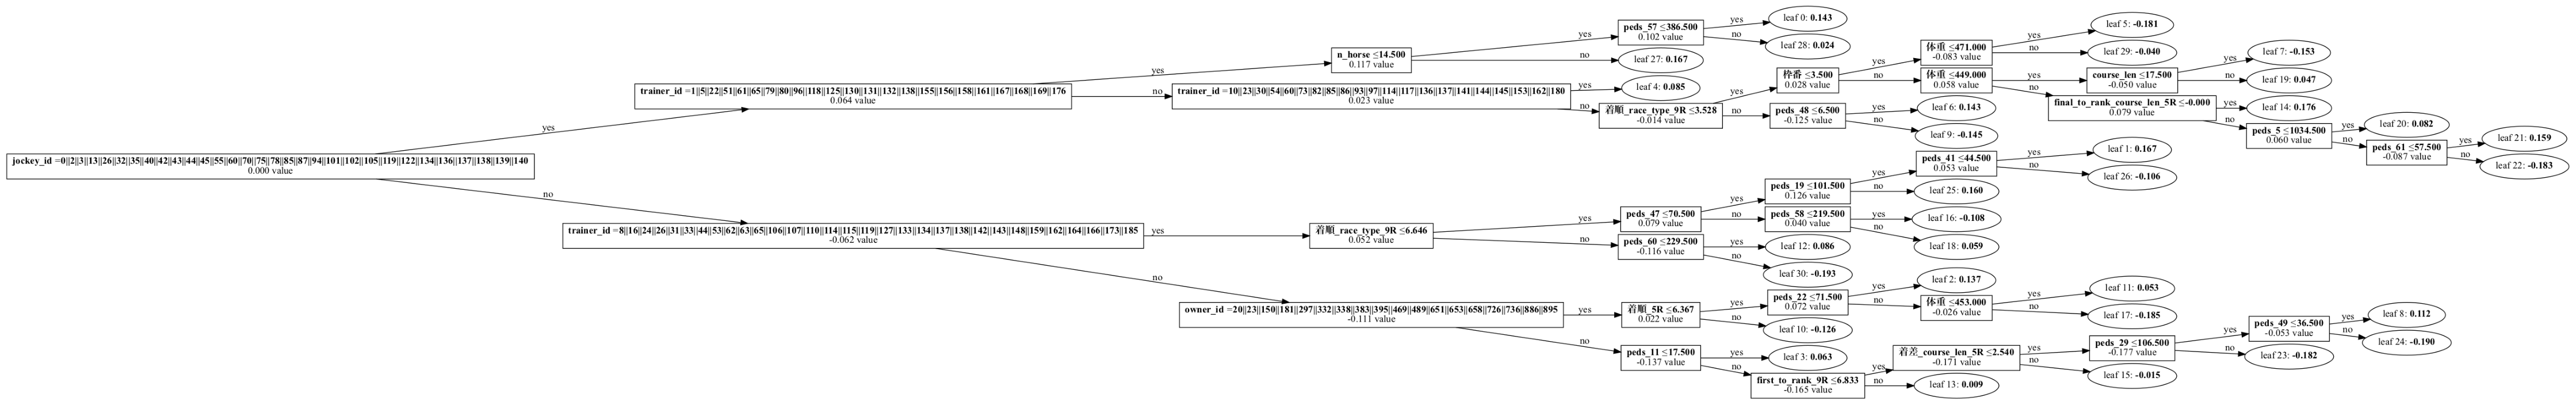

In [24]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = [40, 40]
fig, ax = plt.subplots(figsize=(80, 80), facecolor="w")
# 可視化したい木の番号
tree_index = 0 
lgb.plot_tree(
    booster=lgb_rank,
    tree_index=tree_index,
    show_info='internal_value',
    ax=ax 
    )
plt.show()


# grid search

In [ ]:
# 訓練用, 検証用, simulation用のデータに分割
x_base,y_base,x_test,y_test = funcs.make_data(processed_df,test_size=0.2)
# test_index_list = x_test.index
x_train,y_train,x_valid,y_valid = funcs.make_data(processed_df.loc[x_base.index],test_size=0.2)

# データ作成
train_query = x_train.groupby(x_train.index).size()
valid_query = x_valid.groupby(x_valid.index).size()
train = lgb.Dataset(x_train, y_train, group=train_query)
valid = lgb.Dataset(x_valid, y_valid, reference=train, group=valid_query)

# search用関数
def score(params):
    
    print("Training start:")
    lgb_results={}  #履歴格納用
    lgb_clf = lgb.train(
        params,
        train,
        num_boost_round=1000,
        valid_sets=valid,
        valid_names=['valid'],
        early_stopping_rounds=20,
        verbose_eval=5,
        evals_result=lgb_results,
    )
#     return lgb_results
    return {'loss': -1.0 * lgb_results['valid']['ndcg@3'][lgb_clf.best_iteration], 'status': STATUS_OK}

def optimize(trials):
#探索スペース
    space = {
        #----------定数
        'objective': 'lambdarank',
        'metric': 'ndcg',
        'ndcg_eval_at': [1,2,3],
        'boosting_type': 'gbdt',
        'random_state': 777,
        #----------探索範囲
        'lambdarank_truncation_level': hp.choice('lambdarank_truncation_level',range(1,20)), # 返り値は index
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    }

    max_evals = 25      #探索回数(25くらいで十分)
    best_params = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=max_evals)

    print("best parameters:", best_params)
    return best_params

trials = Trials()
best_params = optimize(trials)


# best_params で 再学習

In [30]:
# best_params セット
lgbm_params = {
                'metric': 'ndcg',
                'objective': 'lambdarank',
                'ndcg_eval_at': [1,2,3],
                'boosting_type': 'gbdt',
                'random_state': 777,
                'force_col_wise':True,
                # ----- best_params ------
                'lambdarank_truncation_level': range(1,20)[best_params['lambdarank_truncation_level']],
                'learning_rate': best_params['learning_rate'],   
            }

# best_params で再び学習
lgb_rank = lgb.train(
    lgbm_params,
    train,
    num_boost_round=100,      
    )


[LightGBM] [Info] Total Bins 29973
[LightGBM] [Info] Number of data points in the train set: 41321, number of used features: 175


# 精度とシミュレーション

In [ ]:
my_simulator = simulator.Simulator(lgb_rank)
result_df = my_simulator.get_result_df(processed_df.loc[x_test.index],return_tables) # 結構時間かかる

In [39]:
%autoreload

データ数少ないので, めっちゃ過学習してる, 7~8年分くらいはデータ必要

In [40]:
detail_dict = funcs.calc_(
    result_df,
    kaime='tansho',    # 買い方, 'fukusho', 'wide', ... 一通り, 買い方準備した
    odds_alpha=1,      # この閾値以上のオッズだったら買う
    bet=100,           # 何円賭けるか
    is_all=True,       # 全レースに賭けるか, False なら round_list のレースにしか賭けない
    round_list=['01'], # ここのレース番号に賭ける
    verbose=True       # 可視化するか否か
    )

的中率             1.0
odds filter 的中率 1.0
収益               6930.0 円
回収率             990.0
レース数           7
賭けたレース数     7
race dist {'01': 1, '02': 1, '03': 1, '04': 1, '05': 1, '06': 1, '07': 1, '08': 0, '09': 0, '10': 0, '11': 0, '12': 0}


# race_id_list

In [40]:
# 今週
race_id_list = ['2022040308{}'.format(str(i).zfill(2)) for i in range(1,13)]
race_id_list += ['2022100408{}'.format(str(i).zfill(2)) for i in range(1,13)]
race_id_list += ['2022010208{}'.format(str(i).zfill(2)) for i in range(1,13)]

# race_id_list += ['2022040307{}'.format(str(i).zfill(2)) for i in range(1,13)]
# race_id_list += ['2022100407{}'.format(str(i).zfill(2)) for i in range(1,13)]
# race_id_list += ['2022010207{}'.format(str(i).zfill(2)) for i in range(1,13)]



# race_id_list += ['2022040306{}'.format(str(i).zfill(2)) for i in range(1,13)]
# race_id_list += ['2022100406{}'.format(str(i).zfill(2)) for i in range(1,13)]
# race_id_list += ['2022010206{}'.format(str(i).zfill(2)) for i in range(1,13)]
# race_id_list += ['2022090303{}'.format(str(i).zfill(2)) for i in range(1,13)]
# race_id_list += ['2022090304{}'.format(str(i).zfill(2)) for i in range(1,13)]

# race_id_list += ['2022020103{}'.format(str(i).zfill(2)) for i in range(1,13)]
# race_id_list += ['2022020104{}'.format(str(i).zfill(2)) for i in range(1,13)]
# race_id_list += ['2022020105{}'.format(str(i).zfill(2)) for i in range(1,13)]
# race_id_list += ['2022020106{}'.format(str(i).zfill(2)) for i in range(1,13)]



# Predictor

In [21]:
pt = Predictor(peds,results,horse_results,race_id_list)
# ********* test_size = 0  : ずっと0にしてなかった...
pt.learn_lgb(lgbm_params=lgbm_params,test_size=0)

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/18869 [00:00<?, ?it/s]

pe finish
pe regularizrd


  0%|          | 0/523 [00:00<?, ?it/s]

hr finish


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Total Bins 80424
[LightGBM] [Info] Number of data points in the train set: 121733, number of used features: 172


# 新潟

In [367]:
base  = '2022040308'
pt.predict(base+'07')


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

              馬番    scores
202204030807  14 -0.009576
202204030807   9 -0.409627
202204030807  13 -0.532311
202204030807  15 -0.762949
202204030807   5 -0.815435
202204030807   7 -0.906838
202204030807   4 -0.914260
202204030807  10 -0.931911
202204030807   1 -1.132334
202204030807   3 -1.184594
202204030807  12 -1.283133
202204030807  11 -1.323496
202204030807   2 -1.442930
202204030807   8 -2.367764
202204030807   6 -2.421679


# 小倉

In [365]:
base  = '2022100408'
        #  202210040802 
# for i in ['07','08','09','10','11']:
pt.predict(base+'07')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

              馬番    scores
202210040807  16  0.346642
202210040807  15  0.307885
202210040807   9 -0.091335
202210040807   7 -0.225866
202210040807  11 -0.227937
202210040807   8 -0.343088
202210040807   5 -0.718924
202210040807  12 -1.036220
202210040807  10 -1.153685
202210040807   6 -1.253014
202210040807   2 -1.313656
202210040807  14 -1.360719
202210040807   4 -1.400164
202210040807  13 -1.594319
202210040807   1 -1.810442
202210040807   3 -2.208708


# 札幌

In [364]:
base  = '2022010208'
pt.predict(base+'07')


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

              馬番    scores
202201020807   1 -0.042919
202201020807   8 -0.153212
202201020807  11 -0.487057
202201020807   2 -0.519089
202201020807  14 -0.530410
202201020807   3 -0.704115
202201020807   5 -0.816080
202201020807   6 -0.878614
202201020807  13 -0.924903
202201020807  12 -1.397026
202201020807   9 -1.412963
202201020807  10 -1.533956
202201020807   4 -1.560519
202201020807   7 -1.677366


# 当日の収支計算

return_tables　と, return_tables_todayで形式が異なるので, 形式をそろえる

# 当日 sim 手順

In [22]:
data =  ShutubaTable.scrape(race_id_list, pt.date)
st = ShutubaTable(data)
st.preprocessing()
st.merge_horse_results(pt.hr)
st.merge_peds(pt.pe.peds_cat)
st.process_categorical(pt.r.le_horse, pt.r.le_jockey, pt.r.data_pe)


tsl = TodaySimulater(pt.model)
tsl.return_table_today(race_id_list)
all_results = tsl.get_result_df( st.data_c, tsl.return_tables,race_id_list, kaime='all',odds=1)

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

In [41]:
all_results

,pred_list,actual_rank_list,tansho_odds,fukusho_odds,umaren_odds,wide_odds,umatan_odds,sanrenpuku_odds,sanrentan_odds,wide_comb
202204030801,"[13, 5, 9, 8, 10, 4, 1, 2, 11, 12, 3, 7, 6]","[10, 8, 9]",3.5,"[1.7, 3.3, 3.5]",21.9,"[5.8, 7.6, 14.2]",32.6,64.5,259.7,"[[8, 10], [9, 10], [8, 9]]"
202204030802,"[4, 16, 14, 2, 8, 10, 11, 3, 13, 17, 7, 9, 5, ...","[10, 3, 14]",5.3,"[1.9, 7.2, 2.4]",79.5,"[20.8, 6.6, 33.8]",112.0,160.3,976.7,"[[3, 10], [10, 14], [3, 14]]"
202204030803,"[3, 8, 6, 12, 1, 15, 2, 11, 7, 9, 14, 10, 13, ...","[3, 1, 6]",5.4,"[2.0, 8.1, 9.9]",80.1,"[23.0, 31.9, 104.9]",106.8,649.2,2468.9,"[[1, 3], [3, 6], [1, 6]]"
202204030804,"[11, 1, 10, 13, 16, 6, 12, 5, 8, 2, 14, 17, 3,...","[3, 13, 17]",51.1,"[13.5, 8.6, 8.8]",908.8,"[171.7, 116.9, 77.5]",1698.1,4495.3,32267.6,"[[3, 13], [3, 17], [13, 17]]"
202204030805,"[3, 9, 7, 4, 12, 8, 10, 13, 1, 6, 11, 5, 2]","[6, 4, 1]",3.8,"[1.7, 4.8, 4.2]",28.8,"[12.2, 11.5, 22.9]",40.2,127.1,459.4,"[[4, 6], [1, 6], [1, 4]]"
202204030806,"[15, 17, 18, 7, 16, 12, 9, 8, 10, 1, 14, 13, 1...","[17, 10, 12]",2.5,"[1.4, 8.3, 3.4]",48.4,"[18.6, 7.5, 55.7]",69.4,151.8,535.7,"[[10, 17], [12, 17], [10, 12]]"
202204030807,"[14, 13, 4, 15, 7, 5, 10, 9, 11, 12, 1, 3, 2, ...","[14, 7, 10]",2.5,"[1.4, 2.2, 5.7]",9.5,"[4.5, 11.3, 22.3]",14.8,56.7,175.4,"[[7, 14], [10, 14], [7, 10]]"
202204030808,"[13, 4, 7, 10, 11, 5, 9, 6, 8, 12, 1, 14, 2, 1...","[9, 4, 7]",15.5,"[5.5, 3.5, 8.3]",40.1,"[10.3, 23.8, 11.0]",128.6,168.1,1254.6,"[[4, 9], [7, 9], [4, 7]]"
202204030809,"[8, 7, 10, 2, 13, 1, 12, 14, 4, 9, 6, 3, 11, 5]","[12, 1, 2]",4.6,"[1.9, 2.4, 3.3]",17.7,"[7.8, 10.4, 11.8]",35.7,56.6,255.1,"[[1, 12], [2, 12], [1, 2]]"
202204030810,"[1, 14, 5, 12, 6, 9, 10, 15, 3, 13, 11, 4, 2, ...","[10, 14, 5]",22.4,"[6.9, 8.2, 6.0]",187.3,"[51.3, 46.2, 58.2]",526.3,1058.8,6427.2,"[[10, 14], [5, 10], [5, 14]]"


In [24]:
calc_tansho(all_results,is_today=True)

的中率 0.05555555555555555
収益   -2810.0 円
race dist {'01': 0, '02': 0, '03': 1, '04': 0, '05': 0, '06': 0, '07': 1, '08': 0, '09': 0, '10': 0, '11': 0, '12': 0}


# previous params

In [16]:
all_results


,pred_list,actual_rank_list,tansho_odds,fukusho_odds,umaren_odds,wide_odds,umatan_odds,sanrenpuku_odds,sanrentan_odds,wide_comb
202204030501,"[15, 8, 14, 12, 2, 7, 9, 10, 6, 4, 11, 3, 1, 5...","[15, 8, 12]",3.0,"[1.2, 1.1, 2.2]",2.8,"[1.6, 4.7, 3.5]",7.3,8.3,38.0,"[[8, 15], [12, 15], [8, 12]]"
202204030502,"[1, 15, 7, 13, 3, 14, 5, 10, 8, 11, 6, 2, 12, ...","[15, 5, 1]",5.8,"[1.8, 6.8, 1.3]",88.7,"[25.0, 3.0, 14.0]",170.0,50.2,435.9,"[[5, 15], [1, 15], [1, 5]]"
202204030503,"[1, 7, 12, 9, 15, 5, 13, 14, 2, 4, 11, 3, 10, 8]","[7, 9, 14]",6.9,"[2.1, 4.4, 3.2]",58.4,"[16.5, 8.9, 25.5]",109.5,164.0,942.7,"[[7, 9], [7, 14], [9, 14]]"
202204030504,"[3, 11, 10, 7, 6, 1, 4, 9, 8, 2, 5, 13, 14, 12]","[10, 13, 9]",5.6,"[2.0, 6.3, 1.8]",82.4,"[28.2, 5.6, 17.8]",124.4,93.0,706.4,"[[10, 13], [9, 10], [9, 13]]"
202204030505,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[10, 2, 7]",7.5,"[1.5, 1.8, 1.1]",31.1,"[6.4, 2.5, 3.0]",58.0,9.3,106.7,"[[2, 10], [7, 10], [2, 7]]"
202204030506,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[2, 6, 11]",6.6,"[1.9, 2.5, 1.4]",42.2,"[12.3, 4.9, 5.5]",69.0,40.0,266.0,"[[2, 6], [2, 11], [6, 11]]"
202204030507,"[18, 14, 15, 12, 16, 5, 13, 11, 10, 4, 3, 7, 2...","[12, 16, 4]",6.5,"[2.0, 1.8, 2.2]",19.9,"[6.8, 7.2, 7.5]",32.6,39.6,247.6,"[[12, 16], [4, 12], [4, 16]]"
202204030508,"[1, 12, 8, 15, 9, 7, 13, 11, 4, 5, 10, 6, 14, ...","[9, 13, 12]",4.6,"[2.0, 5.8, 1.7]",69.7,"[20.4, 3.9, 13.2]",94.9,57.9,473.8,"[[9, 13], [9, 12], [12, 13]]"
202204030509,"[14, 10, 6, 9, 4, 7, 11, 8, 12, 13, 2, 5, 1, 3...","[8, 13, 6]",1.7,"[1.1, 4.6, 1.4]",23.8,"[8.1, 2.1, 18.7]",29.8,32.5,136.6,"[[8, 13], [6, 8], [6, 13]]"
202204030510,"[2, 7, 1, 13, 5, 15, 11, 12, 4, 6, 8, 3, 10, 9...","[13, 11, 5]",3.8,"[1.5, 1.9, 2.2]",11.3,"[4.5, 5.8, 8.3]",19.8,29.9,123.7,"[[11, 13], [5, 13], [5, 11]]"


# 日付に注意

In [47]:
date = '2022/12/31'

# Results scraping

In [ ]:
# race_id_list = results.index.astype('str')

results_tmp = Results.scrape(race_id_list)

# Horse_results scraping

In [ ]:
horse_id_list = results_tmp['horse_id'].astype(str).unique()
horse_results_tmp = HorseResults.scrape(horse_id_list)

# save_path = '/Users/rince/Desktop/Horse/Data/horse_2020.csv'

  0%|          | 0/957 [00:00<?, ?it/s]

# Peds scraping

In [ ]:
peds_2021 = Peds.scrape(horse_id_list)
pe_2021 = Peds(peds_2021)
pe_2021.regularize_peds()
peds_tmp = pe_2021.peds_re

  0%|          | 0/957 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

# Return scraping

In [ ]:
returns_tmp = Return.scrape(race_id_list)


  0%|          | 0/72 [00:00<?, ?it/s]

# update

In [ ]:
new_results = update_data(load_csv(path_win+'results.csv'),results_tmp)
new_horse_results = update_data(load_csv(path_win+'horse_results.csv'),horse_results_tmp)
new_peds = update_data(load_csv(path_win+'peds.csv'),peds_tmp)
returns = load_csv(path_win+'return.csv')
returns.rename(columns={'0':0,'1':1,'2':2,'3':3},inplace=True)
returns_tmp.rename(columns={'0':0,'1':1,'2':2,'3':3},inplace=True)
new_return = update_data(returns,returns_tmp)


# save

In [ ]:
new_results.to_csv(path_win+'results.csv')
new_horse_results.to_csv(path_win+'horse_results.csv')
new_peds.to_csv(path_win+'peds.csv')
new_return.to_csv(path_win+'return.csv')

# 重要度

In [ ]:
importances = pd.DataFrame(
{'features' : x_train.columns, 'importances' : lgb_rank.feature_importance()})
print(importances.sort_values('importances', ascending=False)[:30])

# fastText

流れ
1. fasttext用の血統データの学習データを作る (血統の情報のみ, index ヘッダはいらない)
2. fasttext学習
3. 学習モデルを使って, 血統データをベクトル化
4. ベクトル化して r.data_cに concat
5. 学習
